In [199]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [200]:
#testing parallel run of shorter simulations for Gershman 2012's model, p is the number of simulations to run in parallel

In [201]:
def p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p):
    #index: the index of the weight to be sampled, tuple (i,j)
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_s = (b[:,i,j]-s_n)**2
    w_extended = np.concatenate((w[:,:,0].reshape(p,-1,1),w,w[:,:,-1].reshape(p,-1,1)),axis=2)
    w_extended = np.concatenate((w_extended[:,0,:].reshape(p,1,-1),w_extended,w_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j])**2)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i+2,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j+2])**2)
    E_x = 1/(2*var)*(pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2+pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2)
    return np.exp(-tau*(E_x+E_s))

In [202]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,0].reshape(p,-1,1),pi_l,pi_l[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))

In [203]:
def p_pi_r_new(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,0].reshape(p,-1,1),pi_r,pi_r[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))

In [204]:
def proposal_function_new(z, index, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    i,j = index[0],index[1]
    z_star[:,i,j] = z_star[:,i,j] + sigma*random.normal(size = (p))
    return z_star

In [205]:
def binary_proposal_new(z,index):
    #p: the probability of switch, to stablize the system
    z_star = z.copy()
    z_star[:,index[0],index[1]] = 1-z[:,index[0],index[1]]
    return z_star

In [206]:
def sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p):
    p_w_cur = p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p)
    p_w_star = p_w_new(index,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var,b,tau,gamma,p):
    p_pi_l_cur = p_pi_l_new(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p)
    p_pi_l_star = p_pi_l_new(index,w,x_l,x_r,pi_l_star,var,b,tau,gamma,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var,b,tau,gamma,p):
    p_pi_r_cur = p_pi_r_new(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p)
    p_pi_r_star = p_pi_r_new(index,w,x_l,x_r,pi_r_star,var,b,tau,gamma,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [207]:
def simulation_new(var,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal_new(pi_r, index)
                acc_1 = sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var,b,tau,gamma,p)
                for j in range(p):
                    if acc_1[j] == 1:
                        pi_r[j,:,:] = pi_r_star[j,:,:]

        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal_new(pi_l, index)
                acc_2 = sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var,b,tau,gamma,p)
                for j in range(p):
                    if acc_2[j] == 1:
                        pi_l[j,:,:] = pi_l_star[j,:,:]
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function_new(w, index, p)
                    acc_3 = sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var,b,tau,p)
                    for j in range(p):
                        if acc_3[j] == 1:
                            w[j,:,:] = w_star[j,:,:]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
    return s

In [208]:
var,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,15,15,0,1/100,np.zeros((400,5,5)),5,400,5500,
s = simulation_new(var,beta,gamma,alpha,tau,b,dim,p,no_sample)

Text(0, 0.5, 'no. nodes > 0.5')

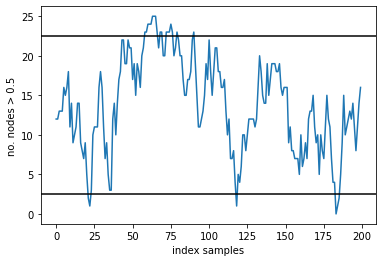

In [226]:
s = np.array(s)
plt.plot(np.array([len(np.where(state>0.5)[0]) for state in s[:,10,:,:]])[2000:2200])
plt.axhline(y=2.5,color = 'k')
plt.axhline(y=22.5,color = 'k')
plt.xlabel('index samples')
plt.ylabel('no. nodes > 0.5')

In [210]:
np.array(s).shape

(5500, 400, 5, 5)

In [211]:
def corr(x,y):
    return (np.mean(x*y)-np.mean(x)*np.mean(y))/(np.var(x)*np.var(y))**0.5

In [212]:
def autocorr(x,y,n):
    #x, y: arrays to calculate correlation
    #n: cover correlation rxy(0) to rxy(n-1)
    rxy = []
    for i in range(n):
        y_shift = np.concatenate((np.zeros(i),y[:(len(y)-i)]))
        rxy.append(corr(x,y_shift))
    return np.array(rxy)

In [213]:
'''corr_list = []
p = 400
s = np.array(s)
for i in range(p):
    corr_list.append(corr(s[:,0,3,1],s[:,i,3,1]))
corr_list = np.array(corr_list)'''

'corr_list = []\np = 400\ns = np.array(s)\nfor i in range(p):\n    corr_list.append(corr(s[:,0,3,1],s[:,i,3,1]))\ncorr_list = np.array(corr_list)'

In [214]:
'''plt.plot(np.arange(400),corr_list)
plt.xlabel('no. sampling sequence')
plt.ylabel('correlation')
plt.title('correlation between sampling sequence 0 and other sequences')
print(np.max(corr_list[1:]))'''

"plt.plot(np.arange(400),corr_list)\nplt.xlabel('no. sampling sequence')\nplt.ylabel('correlation')\nplt.title('correlation between sampling sequence 0 and other sequences')\nprint(np.max(corr_list[1:]))"

In [215]:
'''autocorr_s = autocorr(s[:,0,2,1],s[:,0,2,1],100)
for i in range(1,400):
    autocorr_s = autocorr_s + autocorr(s[:,i,2,1],s[:,i,2,1],100)
autocorr_s = autocorr_s/400'''

'autocorr_s = autocorr(s[:,0,2,1],s[:,0,2,1],100)\nfor i in range(1,400):\n    autocorr_s = autocorr_s + autocorr(s[:,i,2,1],s[:,i,2,1],100)\nautocorr_s = autocorr_s/400'

In [216]:
'''plt.plot(autocorr_s)
plt.xlabel('discrete time (no.step)')
plt.ylabel('correlation')
plt.title('autocorrelogram')
plt.axhline(y=0.05, color='r', linestyle='-')
for i in range(len(autocorr_s)):
    if autocorr_s[i]<0.05:
        print(i)
        break'''

"plt.plot(autocorr_s)\nplt.xlabel('discrete time (no.step)')\nplt.ylabel('correlation')\nplt.title('autocorrelogram')\nplt.axhline(y=0.05, color='r', linestyle='-')\nfor i in range(len(autocorr_s)):\n    if autocorr_s[i]<0.05:\n        print(i)\n        break"

In [217]:
#from node's state to the no. node > 0 in each step
state_no_array = []
for i in range(p):
    state_no_array_i = []
    for j in range(no_sample):
        state_no_array_i.append(len(np.where(s[j,i,:,:]>0.5)[0]))
    state_no_array.append(state_no_array_i)
state_no_array = np.array(state_no_array)

11.70816409090909

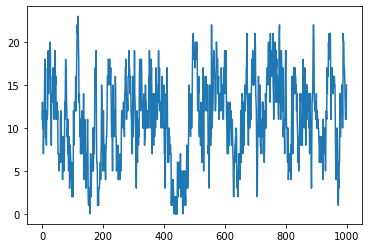

In [218]:
plt.plot(state_no_array[30,2000:3000])
np.mean(state_no_array)

In [219]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>2.5 and state_list_input[i]<2.5:
            cross_list.append((i,2))
        elif state_list_input[i-1]<22.5 and state_list_input[i]>22.5:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

def hist_plot(x,n):
    plt.hist(x,n)
    return np.mean(x),np.std(x)

In [220]:
domi_list = []
for state_list_i in state_no_array:
    domi_list = domi_list + domi_period_count(state_list_i,5)

(157.4206530686911, 124.12642092842081)

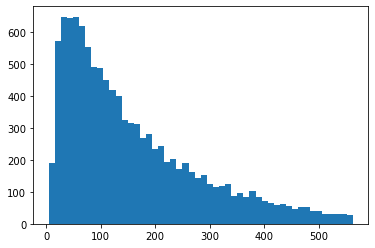

In [221]:
domi_list = np.array(domi_list)
domi_list = np.sort(domi_list)[:-500]
domi_list.shape
hist_plot(domi_list,50)

[1.54772584 0.60183144 2.40389176]


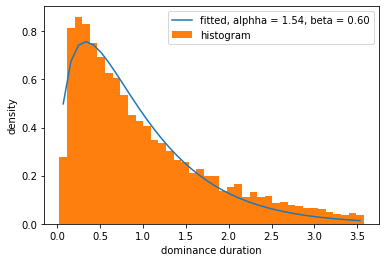

In [227]:
from scipy.optimize import curve_fit
y,bins=np.histogram(domi_list/np.mean(domi_list),40,density=True)
x = []
for i in range(1,41):
    x.append((bins[i]+bins[i-1])/2)
x=np.array(x)

def gamma(x,a,b,c):
    return c*np.exp(-b**-1*x)*x**(a-1)

popt,pcov = curve_fit(gamma,x,y)

plt.plot(x,gamma(x,popt[0],popt[1],popt[2]))
plt.hist(domi_list/np.mean(domi_list),40,density=True)

plt.xlabel('dominance duration')
plt.ylabel('density')
plt.legend(['fitted, alphha = 1.54, beta = 0.60','histogram'])

print(popt)

(0.38831200172125224, 1.325319093448356)

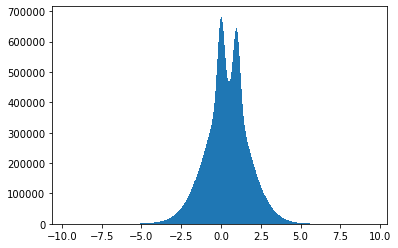

In [223]:
hist_plot(s.reshape(-1),600)